In [11]:
import pandas as pd
import gymnasium as gym
import numpy as np

from dist_plot import plot_q_values_map
from dist_q import EpsilonGreedy
from dist_run import run_env_quantile, postprocess

In [14]:
from typing import NamedTuple
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    n_quantiles: int  # Number of quantiles
    step_reward: int  # Reward at each step
    goal_reward: int  # Reward at goal
    p_random: float  # Probability of random move

params = Params(
    total_episodes=10_000,
    learning_rate=0.1,
    gamma=0.99,
    epsilon=0.1,
    map_size=(14,11),
    seed=123,
    is_slippery=True,
    n_runs=5,
    action_size=None,
    state_size=None,
    n_quantiles=32,
    step_reward=-1,
    goal_reward=10,
    p_random=0.1,
)

rng = np.random.default_rng(params.seed)

In [15]:
res_all = pd.DataFrame()
st_all = pd.DataFrame()

env = gym.make(
    "WindyRooms-v1",
    p_random=params.p_random,
    step_reward=params.step_reward,
    goal_reward=params.goal_reward,
    shape=params.map_size,
    render_mode="rgb_array",
)
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
env.action_space.seed(params.seed)

explorer = EpsilonGreedy(params.epsilon, rng)
rewards, steps, episodes, qtables, all_states, all_actions = run_env_quantile(env, explorer, params)

# Save the results in dataframes
res, st = postprocess(episodes, params, rewards, steps)
res_all = pd.concat([res_all, res])
st_all = pd.concat([st_all, st])
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

env.close()

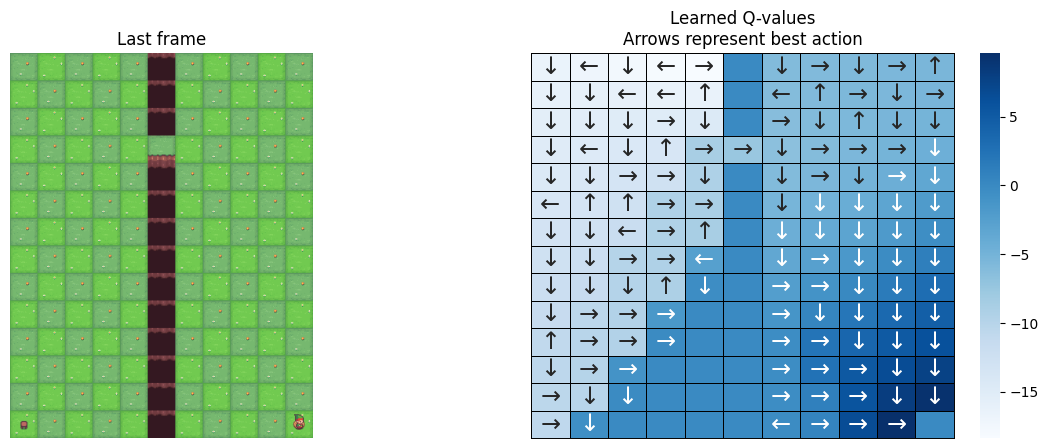

In [16]:
plot_q_values_map(qtables[0].mean(2), env, params.map_size)

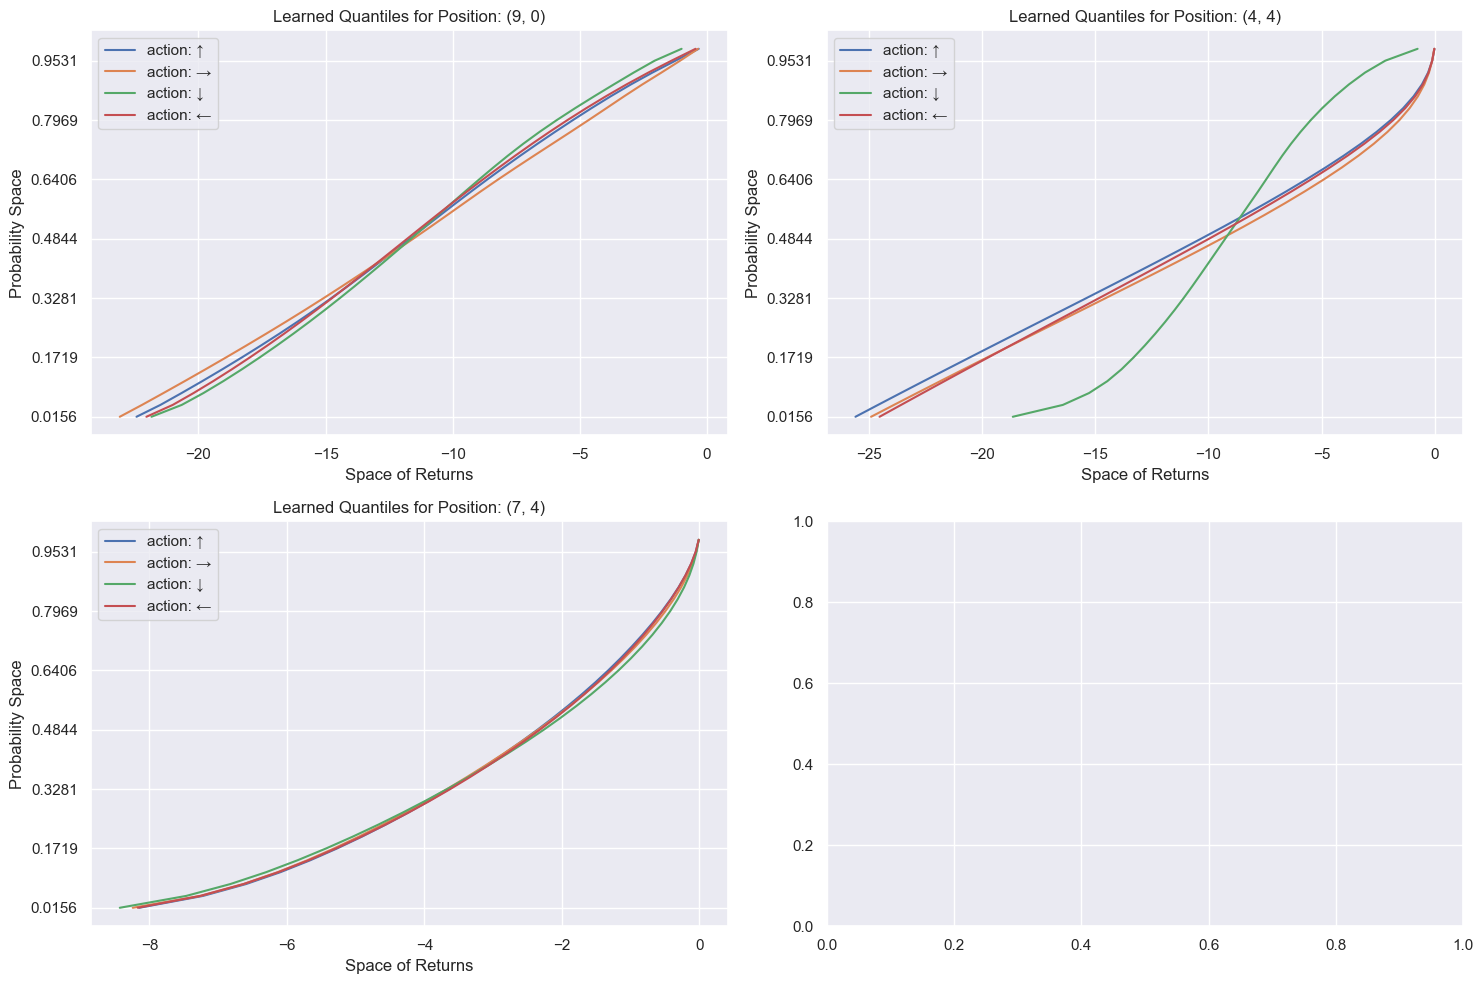

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
tau = ((2 * np.arange(params.n_quantiles) + 1) / (2.0 * params.n_quantiles))
arrow_directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, pos in enumerate([(9, 0), (4, 4), (7, 4)]):
    ax = axes[i]
    state = np.ravel_multi_index(pos, params.map_size)

    for j, quantiles in enumerate(qtable[state]):
        ax.plot(quantiles, tau, label=f"action: {arrow_directions[j]}")

    ax.set_title(f"Learned Quantiles for Position: {pos}")
    ax.set_xlabel("Space of Returns")
    ax.set_ylabel("Probability Space")
    ax.set_yticks(tau[::5])
    ax.legend()

plt.tight_layout()
plt.show()

In [24]:
for i, pos in enumerate([(9, 0), (4, 4), (7, 4)]):
    state = np.ravel_multi_index(pos, params.map_size)
    print(f"action: {i} | q_value : {qtable.mean(2)[state]}")

action: 0 | q_value : [-11.39495482 -11.39500573 -11.3937382  -11.39390719]
action: 1 | q_value : [-10.7764402  -10.13634136  -9.16502134 -10.35738629]
action: 2 | q_value : [-2.76244158 -2.76095979 -2.75727577 -2.75450807]
